In [15]:
import numpy as np
import numpy.typing as npt
from matplotlib import pyplot as plt

# Type aliases for clarity
type Vector3D = npt.ArrayLike[np.float64]
type Matrix3D = npt.NDArray[np.float64]

def rotation_matrix(axis: Vector3D, angle: float) -> Matrix3D:
	axis = axis / np.linalg.norm(axis) # normalize axis vector
	x, y, z = axis
	c = np.cos(angle)
	s = np.sin(angle)
	t = 1 - c
	
	rot_mat = np.array([
		[t*x*x + c, t*x*y - z*s, t*x*z + y*s],
		[t*x*y + z*s, t*y*y + c, t*y*z - x*s],
		[t*x*z - y*s, t*y*z + x*s, t*z*z + c]
	])
	return rot_mat

def tip_matrix(alpha: float, phi: float) -> Matrix3D:
	axis = np.array([np.cos(phi), np.sin(phi), 0])
	angle = alpha
	return rotation_matrix(axis, angle)

def relaxation_terms(t1: float, t2: float, t: float) -> tuple[Vector3D, Vector3D]:
	# decay to 0 for t1 and t2, with extra term for recovery to 1 in the z direction
	e1 = np.exp(-t / t1)
	e2 = np.exp(-t / t2)

	return np.array([e2, e2, e1]), np.array([0, 0, 1 - e1])

def off_res_rotation_matrix(off_res: float, t: float) -> Matrix3D:
	axis = np.array([0, 0, 1])
	angle = 2.0 * np.pi * off_res * t
	return rotation_matrix(axis, angle)

In [16]:
def ssfp_transient_sample_linear_phase_cycling(tr_max: int, tr: float, te: float, t1: float, t2: float, alpha: float, phi: float, delta_phi: float, off_res: float) -> npt.ArrayLike:
	m = np.array([0, 0, 1])
	z = np.array([0, 0, 1])
	samples = []

	tip = tip_matrix(alpha, phi)
	phase_cycle = rotation_matrix(z, delta_phi)
	inverse_phase_cycle = rotation_matrix(z, -delta_phi)
	relax_te_1, relax_te_2 = relaxation_terms(t1, t2, te)
	relax_tr_1, relax_tr_2 = relaxation_terms(t1, t2, tr)
	off_res_rot_te = off_res_rotation_matrix(off_res, te)
	off_res_rot_tr = off_res_rotation_matrix(off_res, tr)

	for _ in range(tr_max):
		# Apply phase cycle and unrotate the coordinate system afterward
		tip = inverse_phase_cycle @ tip @ phase_cycle
		m = tip @ m
		m_after_te = off_res_rot_te @ (relax_te_1 * m + relax_te_2)
		m_xy_sampled = np.linalg.norm(m_after_te[:2])
		samples.append(m_xy_sampled)
		m = off_res_rot_tr @ (relax_tr_1 * m + relax_tr_2)
	
	return samples

def ssfp_transient_steady_state_linear_phase_cycling(tr_max: int, tr: float, te: float, t1: float, t2: float, alpha: float, phi: float, delta_phi: float, off_res: float) -> float:
	m = np.array([0, 0, 1])
	z = np.array([0, 0, 1])

	tip = tip_matrix(alpha, phi)
	phase_cycle = rotation_matrix(z, delta_phi)
	inverse_phase_cycle = rotation_matrix(z, -delta_phi)
	decay, recovery = relaxation_terms(t1, t2, tr)
	off_res_rot = off_res_rotation_matrix(off_res, tr)

	for _ in range(tr_max - 1):
		tip = inverse_phase_cycle @ tip @ phase_cycle
		m = tip @ m
		m = decay * m + recovery
		m = off_res_rot @ m
	
	decay_te, recovery_te = relaxation_terms(t1, t2, te)
	off_res_rot_te = off_res_rotation_matrix(off_res, te)

	tip = inverse_phase_cycle @ tip @ phase_cycle
	m = tip @ m
	m = decay_te * m + recovery_te
	m = off_res_rot_te @ m

	return np.linalg.norm(m[:2]), np.arctan2(m[1], m[0])

In [17]:
type PulseEntry = tuple[float, float, float, float] # (alpha, phi, tr, te)
type PulseSequence = list[PulseEntry]

def ssfp_transient_steady_state_n_periodic(tr_max: int, t1: float, t2: float, off_res: float, pulse_sequence: PulseSequence) -> list[float]:
	n = len(pulse_sequence)

	m = np.array([0, 0, 1])

	tip_sequence = [tip_matrix(alpha, phi) for alpha, phi, _, _ in pulse_sequence]
	relaxation_sequence = [relaxation_terms(t1, t2, tr) for _, _, tr, _ in pulse_sequence]
	off_res_rotation_sequence = [off_res_rotation_matrix(off_res, tr) for _, _, tr, _ in pulse_sequence]

	for idx in range(tr_max - n):
		i = idx % n
		tip = tip_sequence[i]
		decay, recovery = relaxation_sequence[i]
		off_res_rotation = off_res_rotation_sequence[i]

		m = tip @ m
		m = decay * m + recovery
		m = off_res_rotation @ m
	
	relaxation_sequence_te = [relaxation_terms(t1, t2, te) for _, _, _, te in pulse_sequence]
	off_res_rotation_sequence_te = [off_res_rotation_matrix(off_res, te) for _, _, _, te in pulse_sequence]

	outputs = []

	for i in range(n):
		tip = tip_sequence[i]
		decay, recovery = relaxation_sequence_te[i]
		off_res_rotation = off_res_rotation_sequence_te[i]

		m = tip @ m
		m_te = decay * m + recovery
		m_te = off_res_rotation @ m_te
		outputs.append((np.linalg.norm(m_te[:2]), np.arctan2(m_te[1], m_te[0])))
		
		decay, recovery = relaxation_sequence[i]
		off_res_rotation = off_res_rotation_sequence[i]
		m = decay * m + recovery
		m = off_res_rotation @ m
	
	return outputs

In [18]:
# Common parameters
# All time parameters are in seconds

tr_max = 500
tr = 10 / 1000
te = 5 / 1000
t1 = 1000 / 1000
t2 = 100 / 1000

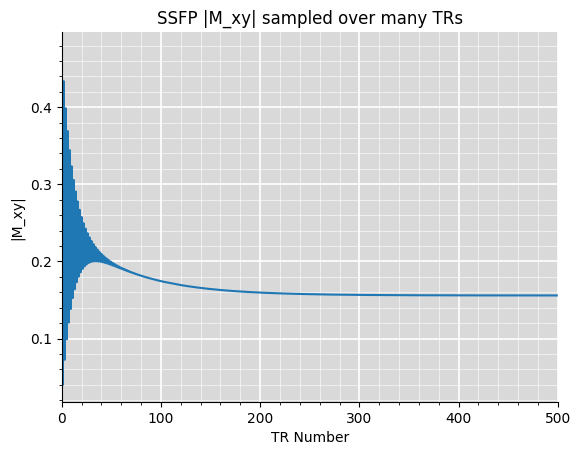

In [19]:
alpha = np.deg2rad(30)
phi = 0
off_res = 0

samples = ssfp_transient_sample_linear_phase_cycling(tr_max, tr, te, t1, t2, alpha, phi, np.deg2rad(180), off_res)

fig, ax = plt.subplots()

ax.plot(samples)

ax.set_title("SSFP |M_xy| sampled over many TRs")
ax.set_xlabel("TR Number")
ax.set_xlim(0, tr_max)
ax.set_ylabel("|M_xy|")

ax.set_facecolor("0.85")
ax.spines[["right", "top"]].set_visible(False)
ax.minorticks_on()
ax.grid(visible=True, which="minor", axis="both", color="white", linewidth=0.4)
ax.grid(visible=True, which="major", axis="both", color="white", linewidth=1.2)

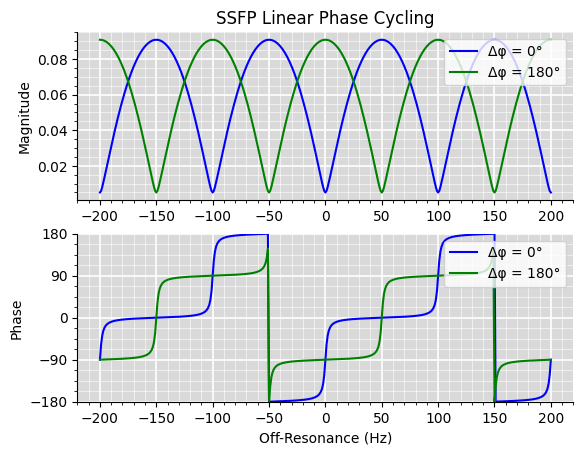

In [20]:
alpha = np.deg2rad(90)
phi = 0
delta_phi = np.deg2rad(180)
off_res_vec = np.linspace(-200, 200, 401)
steady_states_1 = []
steady_states_2 = []

for off_res in off_res_vec:
	steady_states_1.append(ssfp_transient_steady_state_linear_phase_cycling(tr_max, tr, te, t1, t2, alpha, phi, 0, off_res))
	steady_states_2.append(ssfp_transient_steady_state_linear_phase_cycling(tr_max, tr, te, t1, t2, alpha, phi, delta_phi, off_res))

steady_states_1 = np.array(steady_states_1)
steady_states_2 = np.array(steady_states_2)

fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.set_title("SSFP Linear Phase Cycling")
ax1.set_ylabel("Magnitude")

ax1.set_facecolor("0.85")
ax1.spines[["right", "top"]].set_visible(False)
ax1.minorticks_on()
ax1.grid(visible=True, which="minor", axis="both", color="white", linewidth=0.4)
ax1.grid(visible=True, which="major", axis="both", color="white", linewidth=1.2)

ax2.set_xlabel("Off-Resonance (Hz)")
ax2.set_ylabel("Phase")
ax2.set_ylim(-180, 180)

ax2.set_facecolor("0.85")
ax2.spines[["right", "top"]].set_visible(False)
ax2.set_yticks(np.arange(-180, 181, 90))
ax2.minorticks_on()
ax2.grid(visible=True, which="minor", axis="both", color="white", linewidth=0.4)
ax2.grid(visible=True, which="major", axis="both", color="white", linewidth=1.2)

ax1.plot(off_res_vec, steady_states_1[:, 0], label=f"Δφ = 0°", color="b")
ax1.plot(off_res_vec, steady_states_2[:, 0], label=f"Δφ = {np.rad2deg(delta_phi):.0f}°", color="g")
ax1.legend(loc="upper right")
ax2.plot(off_res_vec, np.rad2deg(steady_states_1[:, 1]), label=f"Δφ = 0°", color="b")
ax2.plot(off_res_vec, np.rad2deg(steady_states_2[:, 1]), label=f"Δφ = {np.rad2deg(delta_phi):.0f}°", color="g")
ax2.legend(loc="upper right")

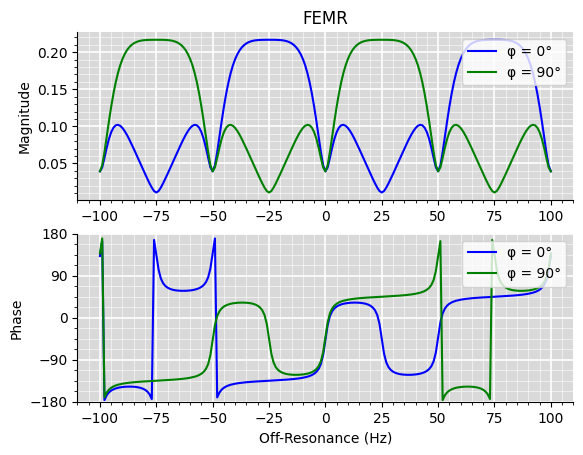

In [22]:
pulse_sequence = [
	[np.deg2rad(20), 0, tr, te],
	[np.deg2rad(20), np.deg2rad(90), tr, te],
]

off_res_vec = np.linspace(-100, 100, 201)
steady_states = []

for off_res in off_res_vec:
	steady_states.append(ssfp_transient_steady_state_n_periodic(tr_max, t1, t2, off_res, pulse_sequence))

steady_states = np.array(steady_states)

steady_states_1 = steady_states[:, 0, :]
steady_states_2 = steady_states[:, 1, :]

fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.set_title("FEMR")
ax1.set_ylabel("Magnitude")

ax1.set_facecolor("0.85")
ax1.spines[["right", "top"]].set_visible(False)
ax1.minorticks_on()
ax1.grid(visible=True, which="minor", axis="both", color="white", linewidth=0.4)
ax1.grid(visible=True, which="major", axis="both", color="white", linewidth=1.2)

ax2.set_xlabel("Off-Resonance (Hz)")
ax2.set_ylabel("Phase")
ax2.set_ylim(-180, 180)

ax2.set_facecolor("0.85")
ax2.spines[["right", "top"]].set_visible(False)
ax2.set_yticks(np.arange(-180, 181, 90))
ax2.minorticks_on()
ax2.grid(visible=True, which="minor", axis="both", color="white", linewidth=0.4)
ax2.grid(visible=True, which="major", axis="both", color="white", linewidth=1.2)

ax1.plot(off_res_vec, steady_states_1[:, 0], label=f"φ = 0°", color="b")
ax1.plot(off_res_vec, steady_states_2[:, 0], label=f"φ = 90°", color="g")
ax1.legend(loc="upper right")
ax2.plot(off_res_vec, np.rad2deg(steady_states_1[:, 1]), label=f"φ = 0°", color="b")
ax2.plot(off_res_vec, np.rad2deg(steady_states_2[:, 1]), label=f"φ = 90°", color="g")
ax2.legend(loc="upper right")

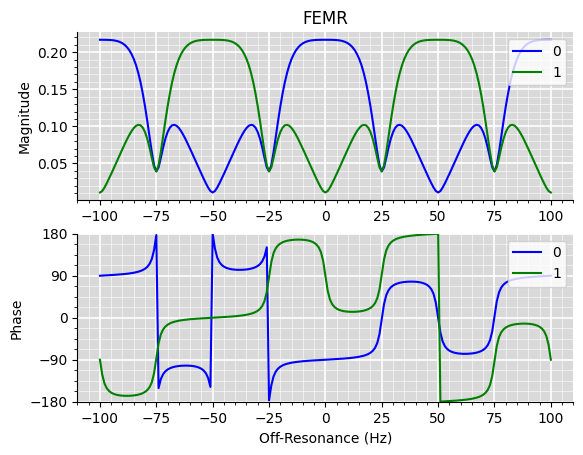

In [37]:
pulse_sequence = [
	[np.deg2rad(20), 0, tr, te],
	[np.deg2rad(20), np.deg2rad(180), tr, te],
	[np.deg2rad(20), np.deg2rad(180), tr, te],
	[np.deg2rad(20), 0, tr, te]
]

off_res_vec = np.linspace(-100, 100, 201)
steady_states = []

for off_res in off_res_vec:
	steady_states.append(ssfp_transient_steady_state_n_periodic(tr_max, t1, t2, off_res, pulse_sequence))

steady_states = np.array(steady_states)

steady_states_1 = steady_states[:, 0, :]
steady_states_2 = steady_states[:, 1, :]

fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.set_title("FEMR")
ax1.set_ylabel("Magnitude")

ax1.set_facecolor("0.85")
ax1.spines[["right", "top"]].set_visible(False)
ax1.minorticks_on()
ax1.grid(visible=True, which="minor", axis="both", color="white", linewidth=0.4)
ax1.grid(visible=True, which="major", axis="both", color="white", linewidth=1.2)

ax2.set_xlabel("Off-Resonance (Hz)")
ax2.set_ylabel("Phase")
ax2.set_ylim(-180, 180)

ax2.set_facecolor("0.85")
ax2.spines[["right", "top"]].set_visible(False)
ax2.set_yticks(np.arange(-180, 181, 90))
ax2.minorticks_on()
ax2.grid(visible=True, which="minor", axis="both", color="white", linewidth=0.4)
ax2.grid(visible=True, which="major", axis="both", color="white", linewidth=1.2)

colors = ["b", "g"]
for i in range(2):
	ax1.plot(off_res_vec, steady_states[:, i, 0], label=f"{i}", color=colors[i])
	ax2.plot(off_res_vec, np.rad2deg(steady_states[:, i, 1]), label=f"{i}", color=colors[i])

ax1.legend(loc="upper right")
ax2.legend(loc="upper right")